# Project Final Report

### Due: Midnight on April 27 (2-hour grace period) — 50 points  

### No late submissions will be accepted.




In [2]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns
import matplotlib.pyplot as plt



# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict, KFold
# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42
# combined_results = pd.DataFrame()     # this is read in after so commenting out here for Stability
# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.2f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


# Format Time for GridSearchCV
def format_time(seconds):

    # Convert seconds to hours, minutes, and remaining seconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60

    # Return a formatted string
    if hours == 0 and minutes == 0:
        return f"{seconds:.4f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"




## Overview

Your final submission consists of **three components**:



---

### 1. Final Report Notebook [40 pts]

Complete all sections of this notebook to document your final decisions, results, and broader context.

- **Part A**: Select the single best model from your Milestone 2 experiments. Now that you’ve finalized your model, revisit your decisions from Milestones 1 and 2. Are there any steps you would change—such as cleaning, feature engineering, or model evaluation—given what you now know?

- **Part B**: Write a technical report following standard conventions, for example:
  - [CMU guide to structure](https://www.stat.cmu.edu/~brian/701/notes/paper-structure.pdf)
  - [Data science report example](https://www.projectpro.io/article/data-science-project-report/620)
  - The Checklist given in this week's Blackboard Lesson (essentially the same as in HOML).
    
  Your audience here is technically literate but unfamiliar with your work—like your manager or other data scientists. Be clear, precise, and include both code (for illustration), charts/plots/illustrations, and explanation of what you discovered and your reasoning process.

The idea here is that Part A would be a repository of the most important code, for further work to come, and Part B is
the technical report which summarizes your project for the data science group at your company. Do NOT assume that readers of Part B are intimately familiar with Part A; provide code for illustration as needed, but not to run.

Submit this notebook as a group via your team leader’s Gradescope account.

---

### 2. PowerPoint Presentation [10 pts]

Create a 10–15 minute presentation designed for a general audience (e.g., sales or marketing team).

- Prepare 8–12 slides, following the general outline of the sections of Part B.
- Focus on storytelling, visuals (plots and illustrations), and clear, simplified language. No code!
- Use any presentation tool you like, but upload a PDF version.
- List all team members on the first slide.

Submit as a group via your team leader’s Gradescope account.

---

### 3. Individual Assessment

Each team member must complete the Individual Assessment Form (same as in Milestone 1), sign it, and upload it via their own Gradescope account.

---

## Submission Checklist

-  Final Report Notebook — Team leader submission
-  PDF Slides — Team leader submission
-  Individual Assessment Form — Each member submits their own


____

____

## Part A: Final Model and Design Reassessment [10 pts]

In this part, you will finalize your best-performing model and revisit earlier decisions to determine if any should be revised in light of your complete modeling workflow. You’ll also consolidate and present the key code used to run your model on the preprocessed dataset, with thoughtful documentation of your reasoning.

**Requirements:**

- Reconsider **at least one decision from Milestone 1** (e.g., preprocessing, feature engineering, or encoding). Explain whether you would keep or revise that decision now that you know which model performs best. Justify your reasoning.
  
- Reconsider **at least one decision from Milestone 2** (e.g., model evaluation, cross-validation strategy, or feature selection). Again, explain whether you would keep or revise your original decision, and why.

- Below, include all code necessary to **run your final model** on the processed dataset. This section should be a clean, readable summary of the most important steps from Milestones 1 and 2, adapted as needed to fit your final model choice and your reconsiderations as just described.

- Use Markdown cells and inline comments to explain the structure of the code clearly but concisely. The goal is to make your reasoning and process easy to follow for instructors and reviewers.

> Remember: You are not required to change your earlier choices, but you *are* required to reflect on them and justify your final decisions.


## **Part A: Prelude**
**Import important datasets and functions to be used in analysis and writeup**

### **Import Dataset(s)**

Providing all dataframe checkpoints throughout Milestone 2 for team members to reference or use in functions as part of the report preparation.

In [3]:
# Original DataFrame from part 1
milestone_1_df = pd.read_csv('Datasets_Results/milestone_1_df.csv')

# Baseline DF used for Baseline Modeling
baseline_df = pd.read_csv('Datasets_Results/baseline_df.csv')

# Final Feature Engineering DFs
feature_engineering_df_no_log = pd.read_csv('Datasets_Results/feature_engineering_df_no_log.csv')
feature_engineering_df_log = pd.read_csv('Datasets_Results/feature_engineering_df_log.csv')

# Copy of Feature Engineering DFs for input of Feature Selection
selected_features_df = pd.read_csv('Datasets_Results/selected_features_df.csv')

# Copy of Feature Engineering DFs used for Fine Tuning
fine_tuning_df = pd.read_csv('Datasets_Results/fine_tuning_df.csv')

# =============
#  Results DFs
# =============

# Combined Results Global DF that Subsequent Results are appended to
combined_results_df = pd.read_csv('Datasets_Results/combined_results.csv')

# Ranked Results Filtering for Part 4 Plotting (filtering out anything that happened during fine-tuning)
ranked_results = pd.read_csv('Datasets_Results/ranked_results.csv')
ranked_results1 = ranked_results[['model', 'mean_CV_RMSE', 'std_CV_RMSE', 'training_RMSE', 'run_comment']].sort_values(by='mean_CV_RMSE', ascending=True)
ranked_results_pre_part4 = ranked_results1[~ranked_results1['run_comment'].str.contains('Fine-')]

# Copy of Combined Results with Extra Columns for Plotting in Write up
combined_results_part4 = pd.read_csv('Datasets_Results/combined_results_part4.csv')

### **Prelude: Functions Definitions**

#### **Profile Dataset**

This function was used to quickly profile the number of null and unique values within a dataset throughout our Milestone 1 and Milestone 2 notebooks. We’ve imported it here to verify that the relevant datasets were saved correctly, and because we specifically reference its results in our subsequent report.

In [4]:
# ========================================================================================
# This is meant to consolidate the 'show_null_counts_features' function from before with
# another with 'value' and 'unique' counts later on in this analysis.
# ========================================================================================

def profile_dataset(df):
    # Identify feature types
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')

    # Build a summary DataFrame
    summary = pd.DataFrame({
        'Feature': df.columns,
        'Type': feature_types.values,
        'Null Values': df.isnull().sum().values,
        'Null %': (df.isnull().mean() * 100).round(2).values,
        'Count (Non-Null)': df.count().values,
        'Unique Values': df.nunique().values
    })

    # Sort Values in Summary by % of null values
    summary = summary.sort_values(by='Null %', ascending=False).reset_index(drop=True)

    # Add dataset shape info above the table
    print(f"This dataset contain {df.shape[0]} rows")
    print(f"This dataset contain {df.shape[1]} columns")

    # Display the summary
    return summary

#### **Train Test Split**

Function to train test split the data provided a dataframe and a target column

In [5]:
def train_test_split_data(df, target_col):
    X = df.drop(columns=target_col)
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

#### **Standardization Function**

This function applies the StandardScaler from scikit-learn to numerical features, excluding categorical columns and those that have been one-hot encoded (i.e., columns with two or fewer unique values). It is called within functions like run_model() to ensure that datasets are properly scaled when required.

In [6]:
def standardize_features_train_and_test(X_train, X_test=None, target_column=None, debug=False, return_scaler=False):
    """
    Standardize numerical features in either a single DataFrame or in X_train/X_test split.

    Parameters:
    - X_train: DataFrame to scale (or the only one, for legacy use)
    - X_test: Optional second DataFrame (for train/test split)
    - target_column: Column to exclude from scaling
    - debug: Print details
    - return_scaler: Whether to return the fitted scaler

    Returns:
    - Scaled X_train (or single df), optional X_test, optional scaler
    """
    legacy_mode = X_test is None  # True if using legacy single-DF mode

    # In legacy mode, treat input as single DataFrame
    if legacy_mode:
        df_scaled = X_train.copy()
        numeric_cols = df_scaled.select_dtypes(include='number').columns.tolist()

        if target_column in numeric_cols:
            numeric_cols.remove(target_column)

        numeric_cols_to_scale = [col for col in numeric_cols if df_scaled[col].nunique(dropna=True) > 2]

        if debug:
            print("Scaling columns:", numeric_cols_to_scale)

        scaler = StandardScaler()
        df_scaled[numeric_cols_to_scale] = scaler.fit_transform(df_scaled[numeric_cols_to_scale])

        if return_scaler:
            return df_scaled, None, scaler
        return df_scaled  # legacy-compatible

    # --- New version for X_train/X_test split ---
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy() if X_test is not None else None

    numeric_cols = X_train.select_dtypes(include='number').columns.tolist()
    if target_column and target_column in numeric_cols:
        numeric_cols.remove(target_column)

    numeric_cols_to_scale = [col for col in numeric_cols if X_train[col].nunique(dropna=True) > 2]

    if debug:
        print("Numeric columns to scale:", numeric_cols_to_scale)

    scaler = StandardScaler()
    X_train_scaled[numeric_cols_to_scale] = scaler.fit_transform(X_train[numeric_cols_to_scale])

    if X_test_scaled is not None:
        X_test_scaled = X_test_scaled[X_train_scaled.columns]
        X_test_scaled[numeric_cols_to_scale] = scaler.transform(X_test_scaled[numeric_cols_to_scale])

    if return_scaler and X_test is not None:
        return X_train_scaled, X_test_scaled, scaler

    if X_test is not None:
        return X_train_scaled, X_test_scaled, None

    # Always return 3 values (legacy call with just one dataset)
    if return_scaler:
        return X_train_scaled, None, scaler

    return X_train_scaled, None, None


#### **Another Standardization Function**
Was utilized for manual Standardization outside of the run_model function.

In [7]:
# ===================================================
# Standardize Numeric Features

# This uses the global df_clean_numeric found
# earlier which filters out 'id' and 'flag' variables
# ===================================================

def standardize_features(df, target_column=None, debug=False, return_scaler=False):
    df_scaled = df.copy()
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    if target_column in numeric_cols:
        numeric_cols.remove(target_column)

    # Step 4: Further exclude binary (0/1) columns
    numeric_cols_to_scale = [
        col for col in numeric_cols
        if df[col].nunique(dropna=True) > 2
    ]

    # DEBUG
    if debug:
        print("Numeric columns before filtering:", numeric_cols)
        print("Numeric columns after filtering:", numeric_cols_to_scale)

    scaler = StandardScaler()
    df_scaled[numeric_cols_to_scale] = scaler.fit_transform(df_scaled[numeric_cols_to_scale])

    if return_scaler:
        return df_scaled, scaler

    return df_scaled


#### **Run Model Function**

This function served as a basis for running the models in each section of our report. It was modified from its original version in Module 3 materials and edited to include the following:

- **concat_results:** A boolean parameter meant to append results to our global combined_results dataframe. We subsequently used this dataframe to store the results of each of the models throughout the course of the excersice.

- **plot_pred:** A boolean parameter meant to plot the predictions of the trained model against their actual values in the training (or optional: Test set). This is meant to evaluate how the model is performing.

- **target_is_logged:** Another boolean parameter meant to change the Cross Validation strategy in case the target variable was logged.

In [8]:
# New version with test data and scaling:
def run_model(
    model,
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    n_repeats=5,
    n_jobs=-1,
    concat_results=False,
    run_comment=None,
    target_is_logged=False,
    plot_pred=False,
    return_scaler=False,
    **model_params
):
    global combined_results

    # Scale both training and test data
    X_train_scaled, X_test_scaled, scaler = standardize_features_train_and_test(
        X_train=X_train,
        X_test=X_test,
        target_column=None,
        return_scaler=True
    )

    model_instance = model(**model_params) if isinstance(model, type) else model
    model_name = model.__name__ if isinstance(model, type) else model.__class__.__name__

    # --- Cross-validation & training ---
    if target_is_logged:
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        rmse_scores = []

        for train_idx, val_idx in kf.split(X_train_scaled):
            X_tr = X_train_scaled.iloc[train_idx]
            X_val = X_train_scaled.iloc[val_idx]
            y_tr = y_train.iloc[train_idx]
            y_val = y_train.iloc[val_idx]

            model_instance.fit(X_tr, y_tr)
            preds_log = model_instance.predict(X_val)

            y_preds = np.expm1(preds_log)
            y_true = np.expm1(y_val)

            rmse_scores.append(root_mean_squared_error(y_true, y_preds))

        mean_CV_RMSE = np.mean(rmse_scores)
        std_CV_RMSE = np.std(rmse_scores)

        # Fit final model on full training set
        model_instance.fit(X_train_scaled, y_train)
        y_train_pred = np.expm1(model_instance.predict(X_train_scaled))
        y_train_true = np.expm1(y_train)
        training_RMSE = root_mean_squared_error(y_train_true, y_train_pred)

        # Evaluate test set
        test_RMSE = None
        if X_test_scaled is not None and y_test is not None:
            y_test_pred = np.expm1(model_instance.predict(X_test_scaled))
            y_test_true = np.expm1(y_test)
            test_RMSE = root_mean_squared_error(y_test_true, y_test_pred)

        # Ensure test prediction is safe for plotting
        if X_test_scaled is None or y_test is None:
            y_test_pred = None

        if plot_pred:
            plot_predictions(
                y_train_true=y_train_true,
                y_train_pred=y_train_pred,
                y_test_true=y_test_true,
                y_test_pred=y_test_pred,
                title=model_name + " Train vs Test"
            )

    else:
        # Not log-transformed
        neg_mse_scores = cross_val_score(
            model_instance,
            X_train_scaled,
            y_train,
            scoring='neg_mean_squared_error',
            cv=RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=42),
            n_jobs=n_jobs
        )
        rmse_scores = np.sqrt(-neg_mse_scores)
        mean_CV_RMSE = np.mean(rmse_scores)
        std_CV_RMSE = np.std(rmse_scores)

        model_instance.fit(X_train_scaled, y_train)
        y_train_pred = model_instance.predict(X_train_scaled)
        training_RMSE = root_mean_squared_error(y_train, y_train_pred)

        test_RMSE = None
        if X_test_scaled is not None and y_test is not None:
            y_test_pred = model_instance.predict(X_test_scaled)
            test_RMSE = root_mean_squared_error(y_test, y_test_pred)

        # Ensure test prediction is safe for plotting
        if X_test_scaled is None or y_test is None:
            y_test_pred = None

        if plot_pred:
            plot_predictions(
                y_train_true=y_train,
                y_train_pred=y_train_pred,
                y_test_true=y_test,
                y_test_pred=y_test_pred,
                title=model_name + " Train vs Test"
            )

    # --- Collect results ---
    results_df = pd.DataFrame([{
        "model": model_name,
        "model_params": model_instance.get_params(),
        "mean_CV_RMSE": mean_CV_RMSE,
        "std_CV_RMSE": std_CV_RMSE,
        "training_RMSE": training_RMSE,
        "test_RMSE": test_RMSE,
        "run_comment": run_comment
    }])

    if concat_results:
        try:
            combined_results = pd.concat([combined_results, results_df], ignore_index=True)
        except NameError:
            combined_results = results_df

    return (results_df, scaler) if return_scaler else results_df


#### **Plot RMSE Comparison**

This was used throughout the second milestone to plot the Training RMSE, Cross Validation RMSE (and optionally the test RMSE).

In [9]:
def plot_rmse_comparison(df, run_comment_keyword="Base Model Parameters", title="Training vs CV RMSE (Stacked)", figsize=(12, 6)):
    # Filter and sort by mean CV RMSE
    filtered_df = df[df['run_comment'].str.contains(run_comment_keyword, case=False, na=False)]
    filtered_df = filtered_df.sort_values(by='mean_CV_RMSE', ascending=True)

    if filtered_df.empty:
        print(f"No data found with run_comment containing '{run_comment_keyword}'")
        return

    # Determine which RMSE columns exist
    rmse_columns = ['training_RMSE', 'mean_CV_RMSE']
    if 'test_RMSE' in filtered_df.columns and filtered_df['test_RMSE'].notna().any():
        rmse_columns.append('test_RMSE')

    # Melt into long form for seaborn
    stacked_df = filtered_df[['model'] + rmse_columns].melt(
        id_vars='model',
        var_name='RMSE_Type',
        value_name='RMSE_Value'
    )

    # Plot setup
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    plt.figure(figsize=figsize)

    # Bar plot
    barplot = sns.barplot(
        data=stacked_df,
        x='model',
        y='RMSE_Value',
        hue='RMSE_Type'
    )

    # Add labels to bars
    for bar in barplot.patches:
        height = bar.get_height()
        if not pd.isna(height):
            x = bar.get_x() + bar.get_width() / 2
            label = f"${height:,.0f}"
            barplot.text(x, height + 3000, label, ha='center', va='bottom', fontsize=8)

    # Format y-axis
    barplot.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))

    # Final layout
    plt.title(f"{title}: {run_comment_keyword}", fontsize=14, fontweight='bold')
    plt.ylabel("RMSE", fontsize=12)
    plt.xlabel("Model", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="")
    plt.tight_layout()
    plt.show()


#### **Plot Predictons**
This function is called within run_model and is used to generate predicted vs. actual scatter plots when run_model is executed with plot_pred=True. These plots served as a visual indicator throughout the exercise to assess model performance and detect potential overfitting.

In [10]:
from matplotlib.ticker import FuncFormatter

def plot_predictions(
    y_train_true=None, y_train_pred=None,
    y_test_true=None, y_test_pred=None,
    title="Model Performance",
    limit_outliers=True,
    figsize=(10, 5)
):
    plots = []

    # Helper: Clean and trim outliers
    def prepare_data(y_true, y_pred):
        y_true = pd.Series(y_true).reset_index(drop=True)
        y_pred = pd.Series(y_pred).reset_index(drop=True)
        if limit_outliers:
            threshold = y_true.quantile(0.99)
            mask = y_true < threshold
            y_true = y_true[mask]
            y_pred = y_pred[mask]
        abs_errors = np.abs(y_true - y_pred)
        return y_true, y_pred, abs_errors

    # Dollar formatter
    dollar_fmt = FuncFormatter(lambda x, _: f"${x/1e6:.1f}M")

    # Collect valid plots
    if y_train_true is not None and y_train_pred is not None:
        ytt, ytp, ae = prepare_data(y_train_true, y_train_pred)
        plots.append(("Train", ytt, ytp, ae))

    if y_test_true is not None and y_test_pred is not None:
        ytt, ytp, ae = prepare_data(y_test_true, y_test_pred)
        plots.append(("Test", ytt, ytp, ae))

    if not plots:
        print("⚠️ No valid prediction data provided for plotting.")
        return

    # Adjust size for single plot
    if len(plots) == 1:
        figsize = (figsize[0] // 2, figsize[1])

    # Create subplots
    fig, axes = plt.subplots(1, len(plots), figsize=figsize)
    if len(plots) == 1:
        axes = [axes]

    # Plot each subplot
    for i, (ax, (label, y_true, y_pred, abs_errors)) in enumerate(zip(axes, plots)):
        scatter = sns.scatterplot(
            x=y_true,
            y=y_pred,
            hue=abs_errors,
            palette="coolwarm",
            ax=ax,
            s=30,
            alpha=0.6,
            edgecolor=None
        )
        ax.plot(
            [y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            'r--'
        )
        ax.set_title(f"{label} Predictions")
        ax.set_xlabel("Actual Values")
        ax.set_ylabel("Predicted Values")
        ax.xaxis.set_major_formatter(dollar_fmt)
        ax.yaxis.set_major_formatter(dollar_fmt)

        # Show legend only for last subplot if multiple
        if len(plots) == 1 or i == len(plots) - 1:
            ax.legend(
                title="Absolute Error",
                loc='upper center',
                bbox_to_anchor=(0.5, -0.25),
                ncol=3,
                frameon=False
            )
        else:
            ax.get_legend().remove()

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


____

## **Part A: Best Model Run**

After milestone 2, our Cross Validation and train set results were as follows:

![Pre_4_Results](https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Figures/Final_Results_Figures/All_Tests_Sorted_by_CV_RMSE.png?raw=1)

**Final Model Decision:**

After Milestone 2, Gradient Boosted Trees appeared to be the most likely top performer. Although its cross-validated (CV) RMSE was approximately $500 higher than that of the Random Forest model, the Random Forest (which had the lowest Mean CV RMSE) showed a significantly lower RMSE on the training set, raising concerns about potential overfitting.

However, after evaluating performance on the test set, the Random Forest model demonstrated superior generalization—not only outperforming the Gradient Boosted Trees model but also achieving the best overall performance across all models tested.

For this reason, we selected the Random Forest model (trained on the full feature set without applying a log transformation to the target variable) as our final and best-performing model.

### **Best Model -- Random Forest Final Model Run**

**Train Test Split and Standardization:**


In [19]:
# Best Performance was on Non-Log Transformed Dataset (Standardized in Part 2.2))
feature_engineering_X_train_no_log, feature_engineering_X_test_no_log, feature_engineering_y_train_no_log, feature_engineering_y_test_no_log = train_test_split_data(feature_engineering_df_no_log, 'taxvaluedollarcnt')
scaled_feature_engineering_x_train_no_log = standardize_features(feature_engineering_X_train_no_log)

**Random Forest Best Parameters**

In [20]:
# Random Forest Best Parameters found in Part 4 of Milestone 2. Expressed as a dictionary to be passed into the run_model call below: 

RF_Best_Params = {
 'max_depth': 21,
 'max_features': 8,
 'n_estimators': 97,
 'bootstrap' : True
 }

**Random Forest Final Model Run**

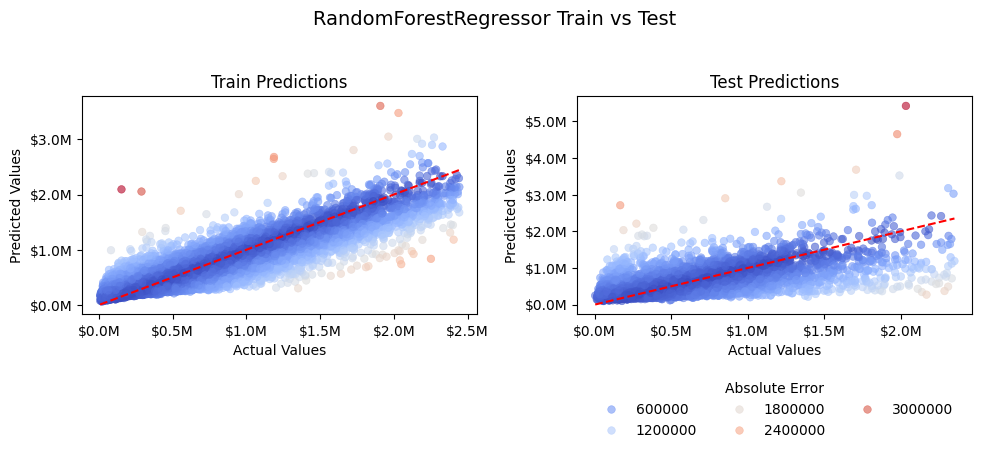

,model,model_params,mean_CV_RMSE,std_CV_RMSE,training_RMSE,test_RMSE,run_comment
0,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",401059.530087,37555.123758,197622.508018,351095.389149,Random Forest Fine-Tuning No Log


In [ ]:
run_model(
          model=RandomForestRegressor,
          X_train=feature_engineering_X_train_no_log,
          y_train=feature_engineering_y_train_no_log,
          X_test=feature_engineering_X_test_no_log,
          y_test=feature_engineering_y_test_no_log,
          n_repeats=5,
          n_jobs=-1,
          concat_results=False,
          run_comment="Random Forest Fine-Tuning No Log",
          target_is_logged=False,
          plot_pred=True,
          **RF_Best_Params
          )

#### **Final Model – Test Set RMSE: $351,095**

____

#### **Random Forest Model**

**Train Test Split and Standardization:**


In [ ]:
# Unlogged DataSet (Standardized in Part 2))
feature_engineering_X_train_no_log, feature_engineering_X_test_no_log, feature_engineering_y_train_no_log, feature_engineering_y_test_no_log = train_test_split_data(feature_engineering_df_no_log, 'taxvaluedollarcnt')
scaled_feature_engineering_x_train_no_log = standardize_features(feature_engineering_X_train_no_log)

**Random Forest Best Parameters**

In [ ]:
RF_Best_Params = {
 'max_depth': 21,
 'max_features': 9,
 'n_estimators': 98,
 'bootstrap' : True
 }

**Random Forest Final Model Run**

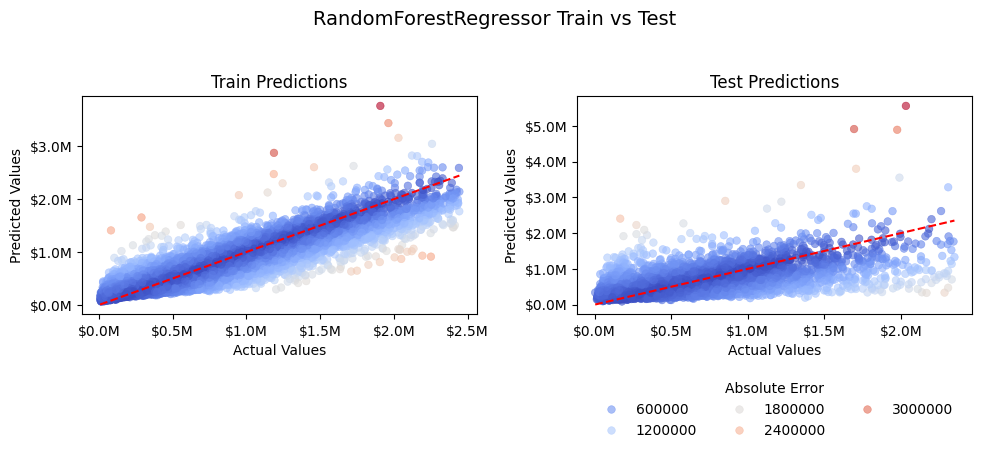

,model,model_params,mean_CV_RMSE,std_CV_RMSE,training_RMSE,test_RMSE,run_comment
0,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",401819.224788,37547.383296,191983.475372,351428.642486,Random Forest Fine-Tuning No Log


In [ ]:
run_model(
          model=RandomForestRegressor,
          X_train=feature_engineering_X_train_no_log,
          y_train=feature_engineering_y_train_no_log,
          X_test=feature_engineering_X_test_no_log,
          y_test= feature_engineering_y_test_no_log,
          n_repeats=5,
          n_jobs=-1,
          concat_results=False,
          run_comment="Random Forest Fine-Tuning No Log",
          target_is_logged=False,
          plot_pred=True,
          **RF_Best_Params
          )

#### **Final Model – Test Set RMSE: $351,429**

___

### **Part A: Overall Summary**

While we acknowledge that further performance gains could potentially be achieved through the reconsiderations discussed below, we stand by the majority of our decisions made in Milestones 1 and 2.

To recap:
- Features were analyzed, and any feature with more than 60% null values was removed.
- Outliers were handled using the IQR method.
- Features irrelevant to the target variable were excluded.
- For feature engineering, non-sensical or overly granular columns were omitted, and similar features were consolidated (e.g., multiple incomplete fireplace-related columns were merged into a boolean feature, has_fireplace_new).
- Feature selection was performed using SequentialFeatureSelector in both forward and backward selection workflows.
- The top three performing models were advanced to Part 4.

Hyperparameter tuning was conducted using models trained on the full feature set from Part 2.2, as this consistently yielded the best average performance. Final model evaluations were conducted across three datasets:

1. The full feature set (no log transformation on the target variable)
2. The full feature set with a log-transformed target variable
3. The ‘best’ feature selection from Part 3

The run_model function was utilized throughout the analysis to streamline training, testing, and evaluation. After each run, results were recorded in the combined_results dataframe, which tracked and ranked model performance across all stages.

Ultimately, the Random Forest model emerged as the best-performing model, demonstrating the lowest CV RMSE and superior test set performance across all combinations of training data, feature sets, and hyperparameter configurations. The final result is as follows:

#### **Final Model – Test Set RMSE: $351,429**

### **Part A: What We Would Have Done Differently**

**Milestone 1:**

For Milestone 1, we opted to forgo more extensive feature tuning because the target variable, taxvaluedollarcnt, was highly skewed. After applying a log transformation, the target approximately resembled a normal distribution. At the time, we believed this would significantly improve model performance by making the data more suitable for prediction. However, in practice, this was not the case. In all of our tests during Milestone 2, models trained on the logged target variable consistently performed worse than those trained on the original scale. Additionally, this approach introduced unnecessary complexity during cross-validation, as predictions had to be transformed back from log space before calculating error metrics.

Overall, if we were to continue this project, re-evaluating the decision to log-transform the target variable would be one of our first priorities, as this assumption did not yield the expected improvements.

**Milestone 2:**

For Milestone 2, all models that underwent hyperparameter tuning did so using the Full Feature Set from Part 2.2, without a log transformation applied to the target variable. Once the hyperparameters were tuned on this dataset, each model was then evaluated—using those same tuned hyperparameters—while being trained on three different datasets:

- The Part 2.2 dataset (no log transformation on the target variable)
- The Part 2 dataset with a log transformation applied to the target variable
- The ‘best’ feature selection from Part 3

This approach was primarily chosen for efficiency, as tuning hyperparameters separately for each dataset would have tripled the workload (resulting in 9 tuning rounds instead of 3). In the future, to maximize model performance, we should re-tune hyperparameters specifically for each dataset. This would be advisable if achieving optimal performance were the primary objective, and especially worthwhile if the shortlist of top-performing models is further narrowed after this round of analysis.



___

____

## Part B: Final Data Science Project Report Assignment [30 pts]

This final report is the culmination of your semester-long Data Science project, building upon the exploratory analyses and modeling milestones you've already completed. Your report should clearly communicate your findings, analysis approach, and conclusions to a technical audience. The following structure and guidelines, informed by best practices, will help you prepare a professional and comprehensive document.

### Required Sections

Your report must include the following sections:


___

#### **1. Executive Summary (Abstract) [2 pts]**
- **Brief overview of the entire project (150–200 words)**
- **Clearly state the objective, approach, and key findings**

**Executive Summary:** The goal of this project is to develop a predictive model using Zillow’s housing dataset to estimate the tax-assessed value of residential properties (taxvaluedollarcnt). By leveraging various home features—such as square footage, location, and year built—the model aims to build on the success of Zillow’s widely-used Zestimate tool by expanding its capabilities to include predictions of a home’s tax-assessed value. This would offer homeowners greater transparency into how their property taxes—one of the most significant ongoing expenses after purchasing a home—are determined.


Our approach is to apply regression techniques to identify key factors influencing property valuations, build a model to predict the taxvaluedollarcnt of different properties based on the data provided by Zillow, and to minimize prediction errors, as evaluated by the use of metrics like Root Mean Squared Error (RMSE).

Our key findings were that while ensemble methods Gradient Boosted Trees and Random Forests yielded RMSEs that were improvements over baseline estimates, models still contained an average error rate north of 300,000 dollars. Due to the trend of models performing significantly worse on homes with taxvalluedollarcnt over 2,000,000 dollars, we suspect that this 'average' is doing significantly worse due to the presence of extreme outliers in the data (some close to 49,000,000 dollars).

___

#### **2. Introduction [2 pts]**
- **Clearly introduce the topic and context of your project**
- **Describe the problem you are addressing (the problem statement)**
- **Clearly state the objectives and goals of your analysis**

Note: You may imaginatively consider this project as taking place in a real estate company with a small data science group in-house, and write your introduction from this point of view (don't worry about verisimilitude to an actual company!).  

**Introduction:** Released 15 years ago, Zillow’s **Zestimate** feature revolutionized transparency in the real estate sector by giving home buyers instant access to accurate, market-based property valuations -- allowing consumers to  easily compare listing prices to market estimates with just a click.

But while this market value is critical during the initial real estate transaction, there is another metric that impacts the finances of homeowners long after the initial purchase, and that is the **tax assessed value**.

Yet despite property taxes represent one of the largest ongoing costs for homeowners across the nation, many homeowners have little visibility into how this value is determined, or whether their value is fair when compared to similar properties.

As part of our in-house data science initiative, we aim to address this gap by leveraging machine learning to develop a model that accurately predicts a property's tax assessed value. In this, our main objectives were clear:

- Identify the most important features when assessing a home's tax value.

- Develop a machine learning model to accurately predict a home's tax assessed value from zillow's database.




___

#### **3. Data Description [2 pts]**
- **Describe the source of your dataset (described in Milestone 1)**
- **Clearly state the characteristics of your data (size, types of features, missing values, target, etc.)**

## 1. Dataset Description

The dataset was sourced from Zillow’s 2017 Kaggle competition *Zestimate Prediction* (Zillow Prize).  
It was provided already reduced to **77,613 rows** and **55 columns** for this project.  
Unlike the original competition, our **target variable** is the **assessed tax value** of properties (`taxvaluedollarcnt`), not the sale price estimate.

- **Features**:
  - A mix of **numerical** and **categorical** features.
  - Several fields are **ID-like numeric references** (e.g., `propertylandusetypeid`, `airconditioningtypeid`) pointing to external master data.
  - To improve clarity and interpretation, mappings were retrieved from the **published Zillow Kaggle source** and used to create dictionaries for meaningful encoding.

- **Key Numerical Features**:
  - `bedroomcnt`, `bathroomcnt`, `calculatedfinishedsquarefeet`, `lotsizesquarefeet`
  - `structuretaxvaluedollarcnt`, `landtaxvaluedollarcnt`, `taxamount`
  - `yearbuilt`, `roomcnt`, `unitcnt`

- **Categorical Features**:
  - Explicit categorical fields: `hashottuborspa`, `propertycountylandusecode`, `propertyzoningdesc`, `fireplaceflag`, `taxdelinquencyflag`
  - Encoded categorical fields: `HeatingOrSystemTypeID`, `PropertyLandUseTypeID`, `StoryTypeID`, `AirConditioningTypeID`, `ArchitecturalStyleTypeID`, `TypeConstructionTypeID`, `BuildingClassTypeID`

- **Target Variable**:
  - `taxvaluedollarcnt` — continuous numerical feature representing the assessed tax value.

**Overall**, the dataset contains a diverse mix of structural, financial, and geographic attributes relevant to property valuation.


____

#### 4. Methodology (What you did, and why)  [12 pts]

**Focus this section entirely on the steps you took and your reasoning behind them. Emphasize the process and decision-making, not the results themselves**


**A. Clearly outline your data cleaning and preprocessing steps**
  - Describe what issues you encountered in the raw data and how you addressed them.
  - Mention any key decisions (e.g., removing samples with too many missing values).
  - What worked and what didn't work?

**B. Describe your feature engineering approach**
  - Explain any transformations, combinations, or derived features.
  - Discuss why certain features were chosen or created, even if they were later discarded.
  - What worked and what didn't work?

**C. Describe your analytical framework**
  - Use of validation curves to see the effect of various hyperparameter choices, and
  - Choice of RMSE as primary error metric

**D. Detail your model selection process**
  - Outline the models you experimented with and why.
  - Discuss how you evaluated generalization (e.g., cross-validation, shape and relationships of plots).
  - Mention how you tuned hyperparameters or selected the final model.



____

**Data Cleaning and Preprocessing**

Several issues were identified in the raw dataset and addressed through a structured cleaning and preprocessing workflow:

---

**Handling Missing Values**

- Columns with more than **60% missing values** were dropped to maintain dataset reliability and modeling quality.
- Features with extreme missingness (**≥90%**) such as `buildingclasstypeid`, `finishedsquarefeet6`, and `storytypeid` were removed entirely.
- Features with moderate missingness (**≥60%**) and deemed non-essential for regression, such as `threequarterbathnbr`, `numberofstories`, and `regionidneighborhood`, were also removed.
- For certain categorical fields (e.g., `fireplaceflag`), missing values were treated as meaningful absence and transformed into binary indicators instead of dropping the feature.

- **Sample Statistics**:
  - Samples before dropping missing target: **77,613**
  - Samples after dropping missing target: **77,578**
  - Samples after further missing value cleaning: **77,274**

---

**Feature Consolidation**

In cases where information was incomplete but potentially valuable, we explored consolidating related features rather than dropping them outright.

- Example: `fireplacecnt` (count of fireplaces) and `fireplaceflag` (presence/absence) were incomplete individually but could be combined into a new binary indicator (`fireplaceflag_new`).
- Consolidation allowed us to retain important signals regarding property features without introducing excessive sparsity or noise.

---

**Handling Duplicate Records**

- **199 duplicate rows** were identified based on the `parcelid` (property ID) and removed to ensure data uniqueness and prevent data leakage into modeling.

---

**Outlier Detection and Removal**

- Extreme outliers in the target variable (`taxvaluedollarcnt`) were detected using the **Interquartile Range (IQR) method**.
- Samples outside the acceptable range were removed to stabilize model training and avoid skewness caused by rare, extreme cases.

The boxplots below illustrate the impact of outlier removal:

![Boxplot comparison of taxvaluedollarcnt before and after outlier removal](https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Figures/taxvaluedollarcnt_outlier.png?raw=1)

---

**Key Decisions**

- Dropped columns with >60% missing values to maintain data quality.
- Removed rows missing the target variable.
- Consolidated related sparse features to preserve useful information.
- Applied IQR-based outlier removal to improve target distribution.

---

**What Worked Well**

- Cleaning highly sparse columns reduced noise and improved modeling performance.
- Feature consolidation preserved meaningful property characteristics.
- Outlier removal significantly stabilized model performance.

**What Didn't Work**

- Overly complex consolidations of rare categories added sparsity and were abandoned.
- Some poorly populated features remained too incomplete despite efforts and were eventually dropped.

---


**4.B. Feature Engineering**


During the feature engineering phase, several transformations, combinations, and new features were developed to improve model performance and better expose the underlying structure of the data.

---

**Transformations and Derived Features**

- **Property Size Transformations**:
  - Log-transformed `calculatedfinishedsquarefeet` to address skewness.
  - Created an outlier flag for properties above the 95th percentile.
  - Added binary indicators for each quartile of property size.

- **Age-Related Features**:
  - Created `propertyage` from `yearbuilt`.
  - Log-transformed `propertyage` and binned `yearbuilt` into decades (`yearbuilt_decade_log`).

- **Ratio Features**:
  - Created `bedroomcnt_by_bathroomcnt` (bedrooms per bathroom ratio).
  - Created `hasgarage_flag_by_bedroomcnt` (garage adjusted by bedroom count).

- **Binary Feature Flags**:
  - Created binary indicators for important features, such as:
    - `hasgarage_flag`
    - `hasairconditioning_flag`
    - `storageshed_flag`

- **Interaction Features**:
  - Built interaction terms between size and age attributes to capture combined effects.

---

**Feature Consolidation**

In addition to creating new features, we also consolidated related sparse or overlapping features:

- **Fireplace-related fields**:
  - `fireplacecnt` and `fireplaceflag` were individually incomplete.
  - These were consolidated into a single binary feature (`fireplaceflag_new`) indicating the presence of a fireplace, capturing useful property information while minimizing sparsity.

- **Garage-related fields**:
  - `garagecarcnt` and `garagetotalsqft` were reviewed together.
  - Where possible, information from both was combined to better represent garage availability.

- **Pool and spa features**:
  - Multiple sparse pool-related fields (`poolcnt`, `poolsizesum`, `pooltypeid2`, `pooltypeid7`) were candidates for consolidation into a general `has_pool_flag`.
  - Consolidation helped reduce complexity and avoided issues with extremely high missingness in individual pool fields.

This feature consolidation allowed us to retain meaningful property characteristics while reducing data sparsity and redundancy.

---

**Distribution Transformation Example**

A comparison of `calculatedfinishedsquarefeet` distributions before and after log transformation shows how the log scale normalized the strong right-skew, making the data more symmetric and suitable for modeling:

![Distribution comparison of calculatedfinishedsquarefeet before and after log transformation](https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Figures/calculatedfinishedsquarefeet_eda.png?raw=1)

---

**Reasoning Behind Feature Choices**

- **Log Transformations** were used to handle heavy skewness in size-related features.
- **Age Groupings** helped capture different value trends in older vs newer homes.
- **Ratio Features** captured relationships between key property dimensions.
- **Binary Flags and Consolidations** helped tree-based models and linear models by creating interpretable, low-dimensional features.

Even features that were later discarded were created based on initial exploratory data analysis (EDA) that suggested potential value.

---

**What Worked Well**

- The log-transformed property size (`calculatedfinishedsquarefeet_log`) improved model stability.
- Binary flags and consolidated fields helped both tree-based and linear models.
- Property age transformations provided additional modeling signals.

**What Didn't Work**

- Log-transforming the target variable (`taxvaluedollarcnt`) worsened performance and was abandoned.
- Highly complex interaction terms did not consistently improve models and sometimes increased overfitting.
- Over-consolidation of rare categories added sparsity and noise without meaningful gains, leading to some fields being ultimately dropped.

---

**Summary**

The feature engineering and consolidation efforts focused on enhancing interpretability, reducing sparsity, and creating stronger signals for both linear and ensemble models, ultimately contributing to more robust and stable model performance.


**4.C. Describe your Analytical Framework**
  - Use of validation curves to see the effect of various hyperparameter choices, and
  - Choice of RMSE as primary error metric

Before proceeding further, we want to clarify that Root Mean Squared Error (RMSE) was used as the primary evaluation metric throughout this analysis. This choice was driven by one key consideration: RMSE is expressed in the same units as the target variable. This makes it an intuitive and meaningful measure of model performance for predicting our target, tax assessed value, in this context -- allowing us to say: 'our predictions are off by 'x' amount on average.'

Additionally, given that this model is intended to be a client-facing feature, accuracy becomes even more critical. Clients would likely be dissatisfied if our predictions of their home’s tax assessed value deviate significantly from the actual value (even if the model excelled in some other evaluation metric). In this context, the difference between predicted and actual values is effectively captured by RMSE. As such, RMSE represents the key source of error we aim to minimize, and it serves as the primary benchmark by which our model’s performance will be evaluated once deployed in production.



Going into hyperparameter tuning, our top five performing MEAN CV RMSE's were as follows:

In [ ]:
ranked_results_pre_part4.head(5)

,model,mean_CV_RMSE,std_CV_RMSE,training_RMSE,run_comment
0,GradientBoostingRegressor,407971.165349,36461.433675,365875.465125,Part 2.2 No target log transformation
1,RandomForestRegressor,410872.953949,34683.618148,153147.700111,Part 2.2 No target log transformation
2,LinearRegression,411237.680017,37334.260560,411888.104579,Final CV with selected features #2
3,Ridge,411525.950273,37275.310043,412178.025168,Final CV with selected features #2
4,Lasso,411900.519368,37106.936802,412229.771396,Final CV with selected features #2


As such our top performing models going into the hyper parameter tuning section of model development were:

- Gradient boosted trees with features from Part 2.2 -- no log transformation
- Random Forest Regression with featuers from Part 2.2 -- no log transformation
- Linear Regression with Final Features from Part 3

For each of these models, the most 'influential' feautres were determined for each using model documentation and Boston Univeristy materials on the issue. From there, parameter sweeps were set up to first test a broad range of possible values for hyperparameters, and results were plotted for the mean CV for each of the hyperparameters.

From there, we used the plots in the first parameter sweeps to either: a) determine a second parameter sweep (if necessary) using curtailed ranges in order to zero in on the best possible range, or b) determine a final range to test for each hyperparameter using Gridsearch Cross Validation. The results are as follows:

**Gradient Boosted Trees**

![GBT_1](https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Figures/GBT1.png?raw=1)

Based on the results of the first parameter sweep, the following ranges were chosen:
- A range of 0 to 0.3 for learning_rate to hone in on the initial optimal region.
- A range of 0 to 10 for max_depth to focus on the first identified area of best performance.
- A range of 0 to 20 for max_features to target the “elbow” of the curve, as performance appeared to plateau beyond this point.
- A range of 0 to 150 for n_estimators to refine around the most promising values observed in the initial sweep.

![GBT_2](https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Figures/GBT2.png?raw=1)

Based on the second parameter sweep, the following final ranges were chosen for the Grid Search Cross Validation:
- n_estimators: 194 – 200
    - (After reviewing standard deviation and performance across both sweeps, this range provided the best balance.)
- max_depth: 4 – 6
    - (Centered around the optimal value from the second sweep, allowing for variance.)
- max_features: 12 – 20
    - (Reflecting the best-performing values from the second sweep, with a margin for error.)
- learning_rate: 0.09 – 0.14 (divided into 5 intervals)
    - (Focused around the optimal value identified in the second sweep, with fine-tuning steps.)

**Grid Search Cross Validation Results**

![GBT_GCV](https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Figures/GBT_GCV.png?raw=1)

The optimal hyperparameters were determined to be a learning_rate of 0.09, max_depth of 5, max_features set to 12, and n_estimators at 194. It’s important to note the scaled and standardized ranges used during tuning to achieve these values.

#### **Random Forest Parameter Sweeps**

![RF1](https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Figures/RF1.png?raw=1)

**Random Forest: First Sweep Discussion:** After the first parameter sweep, the following ranges were selected for further refinement:

n_estimators:
- A second range of 1 to 100 was chosen after the initial sweep indicated a preference for a higher number of estimators, though performance had plateaued. This narrower range on the lower end allowed for greater granularity in evaluation and aimed to prevent potential overfitting.

max_depth:
- A range of 16 to 24 was selected to focus on the optimal value identified in the first sweep, balancing both performance and standard deviation.

max_features:
- Two ranges were chosen for the second sweep:
	- 1 to 10 to evaluate behavior at the lower end of the spectrum.
	- 35 to 45 to explore the best-performing range identified in the first sweep.

bootstrap:
- The first sweep clearly indicated that True was the preferred setting based on both performance and standard deviation. A second plot is included here for completeness and thorough documentation.

![RF2](https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Figures/RF2.png?raw=1)

**Random Forest Second Sweep Discussion:** Based on the results of the second sweep, the following ranges were chosen for the Grid Search CV:

n_estimators:
- 90 - 100 — This range was kept close to the default, as the model consistently favored higher estimator counts in both sweeps. We observed that if given a range up to 500, it would select 500; if given up to 1,000, it would select 1,000. Therefore, we opted to limit the range around the default for efficiency and to avoid unnecessary complexity.

max_depth:
- 20 - 25 — Although the top performer in the second sweep was 17, the performance gain was minimal and largely plateaued. However, a noticeable dip in standard deviation occurred around the 20 - 21 range, suggesting this as an optimal zone for balancing performance and stability.

max_features:
- 8 - 11 — Exploration of the lower half of the range in the second sweep revealed improved performance. As a result, this final range was selected to hone in on that area of higher efficiency.


bootstrap:
- Set to True moving forward, based on consistent performance advantages observed in both sweeps.

**Grid Search Cross Validation results**

![RF_GCV](https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Figures/RF_GCV.png?raw=1)

The optimal parameters for the Random Forest model were a max_depth of 21, max_features set to 8, and n_estimators at 97. It’s also important to note the scale of the output, which reflects the balance between model complexity and performance.

#### **Linear Regression Parameter Sweep**

![LG1](https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Figures/Lg1.png?raw=1)

For Linear Regression, there were only two hyperparameters to adjust:

fit_intercept:

- We opted to set this to True, as there was no meaningful performance improvement observed when excluding the intercept. Retaining the intercept aligns with standard practice unless there’s a strong justification to force the model through the origin.

positive:

- This was set to False, as it’s reasonable to expect that some features may have negative coefficients—not all variables will have a positive relationship with a home’s tax-assessed value. This decision was made despite slight relative performance gains when enforcing positivity. Additionally, the astronomically high Test RMSE indicated poor generalization, causing concerns about this model’s overall reliability.

At this stage, we determined that running a GridSearchCV on the Linear Regression model was likely unnecessary due to its limited hyperparameter options and minimal performance gains. However, we proceeded with the grid search to maintain a rigorous analysis.

![LG_GCV](https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Figures/LG_GCV.png?raw=1)

In this case, although setting fit_intercept = False yielded a slight improvement in performance, we opted for fit_intercept = True based on the considerations discussed earlier, as the marginal performance gains were not worth the potential risk to generalization. Once again, note the use of a scaled and standardized feature set in this context.

**4.D. Detail your model selection process**
  - Outline the models you experimented with and why.
  - Discuss how you evaluated generalization (e.g., cross-validation, shape and relationships of plots).
  - Mention how you tuned hyperparameters or selected the final model.

At the beginning of Part 2, we developed a function called run_model(), which was used throughout the project to consistently evaluate model performance across different stages. The output of run_model() included:

- An updated global output DataFrame that recorded results each time the function was executed, allowing us to track progress across multiple tests.
- An optional plot comparing actual vs. predicted values for each model, enhanced with a heatmap to visualize how closely points aligned with the ideal prediction line.

In [ ]:
# Example global DataFrame after Baseline Test Run

combined_results_df.head(7)

,model,model_params,mean_CV_RMSE,std_CV_RMSE,training_RMSE,test_RMSE,run_comment
0,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",421290.928437,38648.948178,421920.456261,370623.866122,Base Model Parameters
1,Ridge,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",421243.844493,38651.382512,421925.007683,370620.407195,Base Model Parameters
2,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",421286.726566,38648.585390,421920.731761,370616.096743,Base Model Parameters
3,DecisionTreeRegressor,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",565763.310788,23262.481455,19987.231868,534376.427277,Base Model Parameters
4,BaggingRegressor,"{'bootstrap': True, 'bootstrap_features': Fals...",437113.410057,31388.608740,183658.920531,404772.831184,Base Model Parameters
5,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",422464.256360,32148.055755,157307.646717,383765.955426,Base Model Parameters
6,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",413826.783109,34872.625063,376620.459032,384864.541745,Base Model Parameters


These visualizations helped us assess model behavior, particularly in identifying signs of overfitting and understanding performances across different ranges of the target variable. For example, some models predicted lower-value targets accurately but struggled with higher-value predictions, especially when the target variable exceeded $2 million.

Additionally, run_model() tracked Root Mean Squared Error (RMSE) at three key stages:
- Training RMSE
- Cross-Validation RMSE using 5-fold, 5-repeat cross-validation
- Test Set RMSE (utlilized at the end of all tests)

As an a side note, for cases where the target variable was log-transformed, we implemented a parameter within run_model() to handle this scenario. The function applied cross-validation in log space and then inverse-transformed the predictions to calculate RMSE in the original scale. This approach ensured consistency and leveraged KFold to properly simulate repeated cross validation.

At the conclusion of each phase — whether baseline testing, feature engineering, or feature selection — we plotted the Training RMSE against the Cross-Validation RMSE for all candidate models. This allowed us to visually compare performance and detect potential overfitting by observing discrepancies between training and validation errors.



As an example, the plot below displays the training_RMSE and mean_CV_RMSE for each model from the Base Model Parameters run.

![Test_Figure_1](https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Figures/Test_Figure_1.png?raw=1)

Finally, after completing feature selection, we identified the top-performing models for hyperparameter tuning based on their performance and generalization capability. The selected models were:

- Gradient Boosted Trees with full features and no log transformation
- Random Forest with full features and no log transformation
- Linear Regression with selected features and no log transformation

These models demonstrated the best balance between accuracy and robustness, making them strong candidates for further optimization.

Starting with each of the top three models, the four 'most influencial' hyperparamters were chosen based on documentation and Boston University resources. For the **gradient boosted Trees** model these were:

- **learning_rate** - (impact of each tree on learning  (typicall 0 - 1); lower values indicate slower learning)
- **n_estimators** - (Essentially how many trees (in this case boosting stages) are used)
- **max_depth** - (Limits how deep each tree can grow)
- **max_features** - (How many features are considered at each split)

For the **Random Forest** model they were:
- **n_estimators** - (Essentially, how many trees are used)
- **max_features** - (How many feautures are considered for each split)
- **max_depth** - (How deep each tree can grow)
- **booststrap** - (Is bootstrapping used (T/F))

Finally, the **Linear Regression** model didn’t offer many hyperparameters to tune, but the two we could adjust were:
- **fit_intercepts** (Force the model to go through the origin if False (T/F))
- **positive** (Force the model to only have positive coefficients if True (T/F))


The details of our specific hyperparameter choices are outlined in Part 4.C. In general, we used the full-feature, no-log dataset for training, as our top-performing models consistently achieved the best results on this dataset, and we aimed to maintain standardization across tests.

We began by defining broad initial ranges for each hyperparameter to observe their impact on RMSE cross-validation scores. Based on these results, we refined our search by conducting a second parameter sweep to “hone in” on ranges that showed promising behavior. Finally, we used these insights to define a focused range of values for a GridSearchCV to fine-tune the models.

Once we finalized the hyperparameter selections for each model, we conducted final tests using three datasets:
	1.	The no-log full-feature dataset,
	2.	The logged-target dataset, and
	3.	The dataset with selected features from feature selection.

We compared the performance of these tuned models against all prior runs—from baseline models to those with feature engineering and so on — to identify the overall best-performing model.


____

#### 5. Results and Evaluation (What you found, and how well it worked) [10 pts]

**Focus purely on outcomes, with metrics, visuals, and insights. This is where you present evidence to support your conclusions.**

- Provide a clear and detailed narrative of your analysis and reasoning using the analytical approach described in (4).
- Discuss model performance metrics and results (RMSE, R2, etc.)
- **Include relevant visualizations (graphs, charts, tables) with appropriate labels and captions**
- Error analysis
  - Highlight specific patterns of error, outliers, or questionable features.
  - Note anything surprising or worth improving in future iterations.


To improve model stability and prevent skewness from rare, extreme values, we performed outlier removal on the taxvaluedollarcnt variable using the Interquartile Range (IQR) method.

Before removal, the data contained extreme high-value outliers (up to ~50 million), severely distorting the distribution (see boxplot in part4). After removal, the distribution was much more normalized, with values largely constrained below ~$1.2M, creating a tighter range that supports more reliable model training

After hyperparameter tuning and evaluation in Milestone 2, we compared models based on Root Mean Squared Error (RMSE) on both the Cross-Validation (CV) sets and the Training set.
The key performance results are summarized below:

Best CV RMSE: Random Forest Fine-Tuning No Log at $401,543

Best Training RMSE: Random Forest Fine-Tuning No Log at $192,416


Random Forest Fine-Tuning No Log achieved the lowest CV RMSE, indicating the strongest performance on unseen data.

However, there is a substantial gap between training RMSE and CV RMSE (Training: ~192k vs CV: ~401k), suggesting moderate overfitting.

GBT Fine-Tuning No Log had very similar CV RMSE (~$402k) but a smaller gap between training and validation scores, implying slightly better generalization at the cost of a tiny drop in raw accuracy.The trade-off is between slightly better raw performance (Random Forest) and slightly more generalizable behavior (GBT).

The test set serving as the ultimate judge so we pick the Random Forest model as the best model.

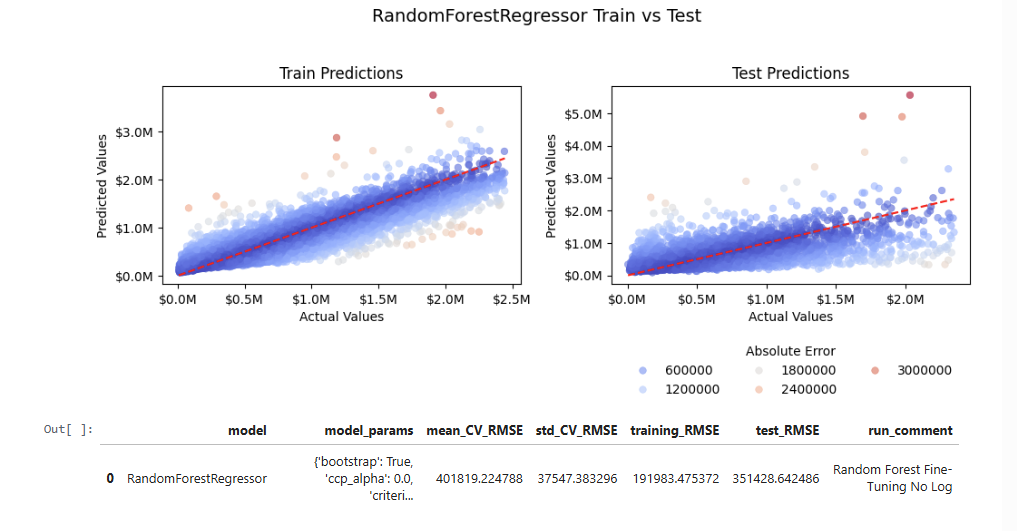

Train Predictions showed a tight clustering along the ideal 45-degree line, indicating strong fit.

The Test Predictions Plot compares the model’s predicted home values against the actual values on unseen data. Test Predictions maintained a relatively strong correlation but showed greater dispersion, especially for higher-valued properties.

Blue shades indicate smaller errors and Red shades represent larger errors. Absolute Error (color-coded by magnitude) increased notably for homes above ~$2M, suggesting the model struggles with predicting very expensive properties.
Some properties are systematically underpredicted, suggesting model difficulty generalizing for luxury or atypical properties

____

#### 6. Conclusion [2 pts]
- Clearly state your main findings and how they address your original objectives
- Highlight the business or practical implications of your findings
- Discuss the limitations and constraints of your analysis clearly and transparently
- Suggest potential improvements or future directions

Gradient Boosted Trees (GBT) and Random Forest emerged as the top-performing models, both achieving improvements in RMSE over the baseline estimates. Models trained without log-transforming the target variable performed better than those utilizing the log transformation. Notably, Random Forest outperformed GBT on the test set, raising concerns about potential overfitting in the GBT model due to its complexity and sensitivity to training data variability.

These findings carry important practical implications for real estate professionals, homeowners, investors, and policymakers. Real estate investors can leverage more accurate property tax assessments to better evaluate the profitability and long-term costs of investments. Homeowners can use these improved predictions for financial planning, helping to reduce uncertainty around future tax obligations. Policymakers can also benefit from these insights by more effectively assessing the fairness and impact of tax policies across both high- and low-value properties.

To further strengthen model performance, fine-tuning Random Forest through hyperparameter optimization could help mitigate overfitting and enhance robustness across diverse property value ranges. Additionally, re-examining data transformation approaches or incorporating targeted feature engineering techniques may help address the skewed distribution of property values and improve overall predictive accuracy.

___

## **References**  
1. Kaggle. (2017). Zillow Prize: Zillow’s Home Value Prediction (Zestimate) [Dataset]. Kaggle. https://www.kaggle.com/competitions/zillow-prize-1/data

2. McFarling, L., Zonglin W., & Nelyapenko S. (2024). *Module 3 Milestone 1 [Data analysis notebook]*. GitHub. [https://github.com/LeeMcFarling/Module_3_Milestone_1](https://github.com/LeeMcFarling/Module_3_Milestone_1)

3. McFarling, L., Zonglin W., & Nelyapenko S. (2024). *Module 3 Milestone 2 [Data analysis notebook]*. GitHub. [https://github.com/LeeMcFarling/Module_3_Milestone_1](https://github.com/LeeMcFarling/Module_3_Milestone_2)

4. McFarling, L., Zonglin W., & Nelyapenko S. (2024). *Module 3 Final_Project [Data analysis notebook]*. GitHub. [https://github.com/LeeMcFarling/Final_Project_Writeup](https://github.com/LeeMcFarling/Final_Project_Writeup)

